# <span style="color:blue">Homework 3</span>
## Finance 372 - Prof Travis Johnson

### Due 11:59pm on Friday 3/10/23

**Videos**: Skills you'll need for this assignment are covered in videos 11 through 17 on the YouTube channel https://www.youtube.com/channel/UCm8Lrbs8DkIZ8OHa0VpK2hQ

**Rules**: you must complete this assignment on your own but are allowed to consult lecture notes, the class YouTube channel, other internet resources, and other students via the Discord Channel. If you are using code copies from a website, cite that website. You are still responsible for the quality of the code submitted - it's *your* fault if you copy an unreliable resource

**Deliverables**: submit an `.html` copy (File -> Export Notebook As -> Export Notebook to HTML), your `.ipynb` file, and your `backtest_stats.csv` files via Canvas upload. The HTML file must be readable and include all the output you want us to grade. We will **not** run your code for you, and you will **not** receive credit for solutions that are in code format but do not have readable output in the HTML file.

## Solution by: <span style="color:orange">Siyuan Yang Sy9734</span>

In this Homework, you will backtest a ***gross profitability*** strategy by modifying the provided code for the ***book-to-market*** strategy. The gross profitability strategy forms a new portfolio each month with long positions in the top 10% of firms by gross profitability, and short positions in the bottom 10% of firms by gross profitability. The portfolio should be **value-weighted**.

As our gross profitability measure, we'll use annual revenue (REVT), minus annual cost of goods sold (COGS), scaled by prior-year book value of assets (AT) from the COMPUSTAT Fundamental Annual dataset on WRDS:
$$GP_y=\frac{REVT_y - COGS_y}{AT_{y-1}}$$

In [250]:
import pandas as pd
import datetime as dt
import numpy as np
from pathlib import Path

## <span style="color:blue">Task 1</span>: Run a backtest for the book-to-market strategy using the included code

Run the included backtest.ipynb. If you haven't messed with the folder structure, it should run a backtest for the book-to-market strategy. No need to include anything in this notebook as a response to this task.

## <span style="color:blue">Task 2</span>: Download annual data on net income and book values of equity

Following the instructions in Video 17 (WRDS), download annual data from 1960--2020 containing REVT, COGS, and AT columns as a Stata (.dta) file. Load these into a DataFrame called `signal_df`.

In [251]:
signal_df = pd.read_stata('annual_data.dta')

Now remove unnecessary columns, keeping only gvkey, datadate, at, cogs, and revt. Write the edited dataframe into a .dta file using `.to_stata('gp_data.dta',write_index=False)`

In [252]:
signal_df = signal_df.loc[:,['gvkey','revt','cogs','at','datadate']]
signal_df.to_stata('gp_data.dta',write_index=False)

Run this cell without editing it to show us what your signal_df looks like:

In [253]:
signal_df

,gvkey,revt,cogs,at,datadate
0,001000,0.900,NaN,NaN,1961-12-31
1,001000,1.600,NaN,NaN,1962-12-31
2,001000,1.457,1.065,NaN,1963-12-31
3,001000,2.032,1.474,1.416,1964-12-31
4,001000,1.688,1.342,2.310,1965-12-31
...,...,...,...,...,...
507431,351038,0.000,0.000,1.378,2020-12-31
507432,351491,13408.000,10714.000,17847.000,2019-12-31
507433,351491,12549.000,10413.000,18841.000,2020-12-31
507434,351590,51894.216,39804.942,62131.888,2019-12-31


## <span style="color:blue">Task 3</span>: Create a ProfDataProcessor

Copy and modify the BMDataProcessor to create a GPDataProcessor class. It should load the same `price_df` as before (from the monthly_returns.csv file) but a new `signal_df` with revt, cogs, and lag_at columns (in addition to the date and security_id columns). The lag_at column should contain the prior year's at value, which you can get using the included  `safe_lead_lag` method

Let's be very conservative and say we can't rely on having accounting data until 120 days after the end of the fiscal year ('datadate' column). Assume we are willing to use accounting data up to two years old.

***HINT***: be sure to change the `data_folder_path`, `min_accounting_lag`, `max_accounting_lag`, and the constructor `__init__(self)` to reflect the new strategy. The `unique_dates()` and `signal_df_for_date` functions only need to be updated to use datatdate instead of rdq (since we don't have an rdq column in this annual data). These functions will otherwise work as-is, and the other functions don't need to be changed at all.

In [254]:
# Define class here
class GPDataProcessor():
    
    # Path to where we store the data
    data_folder_path = Path('/Users/stevenyang/Desktop/UT Fall 23/FIN 372 /HW3/Homework3') 
    
    # Number of days between quarterly earnings announcement and when we can use data
    min_accounting_lag = 120
    max_accounting_lag = 730
    
    # Minimum share price to open a new position
    min_share_price = 3.0
    
    # Constructor, loads/cleans/merges data as needed
    def __init__(self):
        
        # Load price data: monthly 1961-2020 sample from CRSP including all public US equities
        # In monthly_returns.csv
        self.price_df = pd.read_csv(self.data_folder_path / 'monthly_returns.csv')
        
        # Parse the yyyyMMdd int dates into DateTime64
        # Based on formatting strings here
        # https://docs.python.org/3/library/datetime.html#strftime-and-strptime-behavior
        self.price_df.loc[:,'date'] = pd.to_datetime(self.price_df.loc[:,'date'], format ="%Y%m%d")
        
        # Prices sometimes negative to indicate no volume at closing auction
        # In these cases, price = -0.5*(bid+ask)
        # But we don't use that information and so want prices to always be positive
        # See http://www.crsp.org/products/documentation/data-definitions-p
        self.price_df.loc[:,'prc'] = np.absolute(self.price_df.loc[:,'prc'])
        
        # Add next-months return as a new column 'ret_next'
        # Use the safe_lead_lag: want lead return but only when permno the same
        self.price_df.loc[:,'ret_next'] = safe_lead_lag(self.price_df.loc[:,'ret'],self.price_df.loc[:,'permno'],1)
        
        # Load accounting data used for BM signal
        # Quarterly sample from 1961-2020 from Compustat Fundamentals Quarterly
        # Stored in the `comp_bm.dta` file
        # `.dta` files are Stata data, and do a better job than `.csv` files of remembering data types
        self.signal_df = pd.read_stata(self.data_folder_path / 'gp_data.dta')
        self.signal_df.loc[:,'lag_at'] = safe_lead_lag(self.signal_df.loc[:,'at'],self.signal_df.loc[:,'gvkey'],-1)
        # The problem with our accounting data is that it identifies stocks using gvkey instead of permno
        # To merge with return_df, we need to use another dataset that converts gvkey to permno
        # This is stored in the gvkey_permno_conversion.dta file
        self.gvkey_permno_conversion = pd.read_stata(self.data_folder_path / 'gvkey_permno_conversion.dta')

        # Use a merge command to add the permno column to our signal_df
        self.signal_df = self.signal_df.merge(self.gvkey_permno_conversion,on=['gvkey','datadate'])           
        
    # Returns an array with the unique dates for which we have loaded data
    # Uses from the price_df since that's how frequency we can update portfolio value
    # Filters all dates in price_df to return only dates for which we have signals as well
    def unique_dates(self):
        price_dates = pd.Series( np.sort(self.price_df.loc[:,'date'].unique()) )
        min_signal_date = self.signal_df.loc[:,'datadate'].min() + np.timedelta64(self.min_accounting_lag,'D')
        max_signal_date =  self.signal_df.loc[:,'datadate'].max() + np.timedelta64(self.max_accounting_lag,'D')
        return price_dates[ (price_dates >= min_signal_date) & (price_dates <= max_signal_date) ].array
    
    # Returns a DataFrame containing one row for all securities in price_df as of date.
    # Columns must include:
    # - 'date': date on which price data observed
    # - 'security_id': a security identifier
    # - 'prc': price on date
    # - 'ret': return from previous date to date
    # Ignores liquidity and future-return availability requirements
    # To be used only for closing decisions and execution decisions
    # Some of the returned stocks cannot be traded
    def price_df_for_date(self,date):
        price_date_df = self.price_df.loc[ self.price_df.loc[:,'date'] == date, :]
        return price_date_df.rename(columns={'permno':'security_id'}) 
    
    # Returns a DataFrame where each row is a security in the strategy's universe,
    # Columes must include:
    # - 'date': date on which price data observed
    # - 'security_id': a security identifier
    # - whatever signals the trading rule needs to decide which securities to open new positions in
    #   - In this case, return cshoq, prccq, and ceqq so trading rule can compute B/M ratio
    #
    # Also responsible for applying whatever liquidity filters are wanted to narrow universe,
    # and check that we have future return data (no point in backtesting if we don't know what happens next)
    def signal_df_for_date(self,date):
        # find set of permnos considered tradeable as of date 
                
        # start with all rows return_df on date with non-nan and non-infinite ret_next
        date_price_df = self.price_df.loc[ self.price_df.loc[:,'date'] == date,:]
        date_price_df = date_price_df.loc[ np.isfinite(self.price_df.loc[:,'ret_next']),:]
        date_price_df = date_price_df.drop(columns=['ret_next'])
        
        # now signal data
        # first only look at data announced at least accounting_lag_days prior to date
        all_past_signal_df = self.signal_df.loc[(self.signal_df.loc[:,'datadate'] < date - np.timedelta64(self.min_accounting_lag,'D')),:]
        # then grab only the latest observation for each permno
        latest_signal_df = all_past_signal_df.groupby('permno').last()
        
        # now merge with return data and return        
        merged_df = date_price_df.merge(latest_signal_df,on='permno',how='inner')
        merged_df = merged_df.rename(columns={'permno':'security_id'})  # use permno as our security_id
        
        # filter by liquidity requirements
        merged_df = self.liquidity_filter(merged_df)
        
        # and return without the ret_next column so backtests don't cheat by using it
        return merged_df

    # Returns a filterd version of the passed DataFrame,
    # with all observations deemed too illiquid removed
    # Liquidity requirements:
    #  - price >= $3
    def liquidity_filter(self,df):
        return df.loc[ df.loc[:,'prc'] >= self.min_share_price,:]
        
###################################################################
# Helper methods, do not modify
###################################################################

# Function safe_lead_lag returns a new Series with the lead/lagged values
#  but only when a group is the same for the lead/lag
# Inputs:
# - data_series: data we want to lead/lag
# - group_series: grouping we want to be the same for the lead/lag to be value
# requires data_series and group_series already by sorted by group_series
# so that all alike values of group_series are adjacent,
# meaning group_series should look like:
#    g_0
#    g_0
#    g_0
#    g_0
#    g_1
#    g_1
#    g_2
#    g_2 
#    ...
# where g_i indicates the observation is in group i,
# and once the first g_{i+1} appears no more g_i values appear
# 
# lead_lag > 0 returns a data_series with values of data_series lead_lag rows ahead
# as long as group_series remains the same, NaN if group different
# lead_lag < 0 returns a data_series with values of data_series -lead_lag rows behind 
# (same as lead_lag rows ahead) as long as group_series remains the same, NaN if group different
def safe_lead_lag(data_series,group_series,lead_lag): 
    df = pd.DataFrame({ 'data': data_series, 'group': group_series })
    return df.groupby(['group'])['data'].shift(-lead_lag)

### After running your code above, you should be able to run these tests sucessfully. Please run each cell without editing.

#### Constructor tests: should print price_df and signal_df.

In [255]:
data_processor = GPDataProcessor()

print('data_processor.price_df:')
print(data_processor.price_df)

print('\n\n')
print('data_processor.signal_df:')
print(data_processor.signal_df)

data_processor.price_df:
         permno       date        prc         vol       ret     shrout  \
0         10000 1985-12-31        NaN         NaN       NaN        NaN   
1         10000 1986-01-31    4.37500      1771.0       NaN     3680.0   
2         10000 1986-02-28    3.25000       828.0 -0.257143     3680.0   
3         10000 1986-03-31    4.43750      1078.0  0.365385     3680.0   
4         10000 1986-04-30    4.00000       957.0 -0.098592     3793.0   
...         ...        ...        ...         ...       ...        ...   
3474759   93436 2022-08-31  275.60999   7322218.0 -0.072489  3133470.0   
3474760   93436 2022-09-30  265.25000  12965500.0 -0.037589  3158000.0   
3474761   93436 2022-10-31  227.53999  17325849.0 -0.142168  3157752.0   
3474762   93436 2022-11-30  194.70000  18824244.0 -0.144326  3157752.0   
3474763   93436 2022-12-30  123.18000  29417041.0 -0.367334  3157752.0   

             retx  ret_next  
0             NaN       NaN  
1             NaN -0.25714

#### `unique_dates` test: should return array of unique dates

In [256]:
data_processor.unique_dates()

<DatetimeArray>
['1970-06-30 00:00:00', '1970-07-31 00:00:00', '1970-08-31 00:00:00',
 '1970-09-30 00:00:00', '1970-10-30 00:00:00', '1970-11-30 00:00:00',
 '1970-12-31 00:00:00', '1971-01-29 00:00:00', '1971-02-26 00:00:00',
 '1971-03-31 00:00:00',
 ...
 '2022-03-31 00:00:00', '2022-04-29 00:00:00', '2022-05-31 00:00:00',
 '2022-06-30 00:00:00', '2022-07-29 00:00:00', '2022-08-31 00:00:00',
 '2022-09-30 00:00:00', '2022-10-31 00:00:00', '2022-11-30 00:00:00',
 '2022-12-30 00:00:00']
Length: 631, dtype: datetime64[ns]

#### `price_df_for_date` test: should return DataFrame with all available observations on passed date

In [257]:
unique_dates = data_processor.unique_dates()
test_date = unique_dates[60]

test_price_df = data_processor.price_df_for_date(test_date)
test_price_df

,security_id,date,prc,vol,ret,shrout,retx,ret_next
1089,10006,1975-06-30,42.875,877.0,-0.049861,5700.0,-0.049861,0.005831
2137,10014,1975-06-30,2.375,3263.0,0.266667,5019.0,0.266667,0.157895
7200,10050,1975-06-30,7.000,NaN,0.037037,900.0,0.037037,-0.035714
8312,10057,1975-06-30,9.625,234.0,0.054054,4410.0,0.040541,-0.051948
8597,10058,1975-06-30,NaN,NaN,NaN,1470.0,NaN,NaN
...,...,...,...,...,...,...,...,...
2958171,84794,1975-06-30,7.875,NaN,0.000000,6830.0,0.000000,0.190476
2960999,84911,1975-06-30,NaN,NaN,NaN,364.0,NaN,NaN
2977332,85252,1975-06-30,NaN,NaN,NaN,1919.0,NaN,NaN
3059766,86239,1975-06-30,NaN,NaN,NaN,3966.0,NaN,NaN


#### `signal_df_for_date` test: should return DataFrame with most recent observations meeting liquidity requirements on passed date

In [258]:
test_signal_df = data_processor.signal_df_for_date(test_date)
test_signal_df

,security_id,date,prc,vol,ret,shrout,retx,gvkey,revt,cogs,at,datadate,lag_at,index,fyearq,fqtr
0,10006,1975-06-30,42.875,877.0,-0.049861,5700.0,-0.049861,001010,535.097,401.983,675.170,1974-12-31,580.766,385,1974.0,4.0
2,10057,1975-06-30,9.625,234.0,0.054054,4410.0,0.040541,001098,169.442,126.023,179.895,1974-09-30,105.258,4195,1974.0,4.0
3,10102,1975-06-30,20.500,2477.0,0.086093,11352.0,0.086093,001215,760.178,547.258,661.147,1974-12-31,590.231,9152,1974.0,4.0
4,10137,1975-06-30,17.750,3355.0,0.007222,27292.0,-0.013889,001279,500.646,315.661,1758.437,1974-12-31,1622.440,12309,1974.0,4.0
5,10145,1975-06-30,38.875,4773.0,0.050676,27862.0,0.050676,001300,2215.946,1700.657,1968.449,1974-12-31,1762.536,13133,1974.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2547,80945,1975-06-30,19.750,NaN,0.064000,1025.0,0.053333,011186,69.130,54.075,40.769,1974-12-31,26.557,467091,1974.0,4.0
2548,82705,1975-06-30,15.750,NaN,0.086207,5501.0,0.086207,011453,618.446,571.905,108.784,1974-03-31,71.559,478813,1973.0,4.0
2549,82852,1975-06-30,8.500,NaN,0.236364,3743.0,0.236364,011492,38.409,15.099,45.134,1974-12-31,29.745,480696,1974.0,4.0
2550,82959,1975-06-30,20.125,NaN,0.045455,11928.0,0.045455,011502,388.712,289.728,362.090,1974-12-31,295.953,481186,1974.0,4.0


In [259]:
signal_df

,gvkey,revt,cogs,at,datadate
0,001000,0.900,NaN,NaN,1961-12-31
1,001000,1.600,NaN,NaN,1962-12-31
2,001000,1.457,1.065,NaN,1963-12-31
3,001000,2.032,1.474,1.416,1964-12-31
4,001000,1.688,1.342,2.310,1965-12-31
...,...,...,...,...,...
507431,351038,0.000,0.000,1.378,2020-12-31
507432,351491,13408.000,10714.000,17847.000,2019-12-31
507433,351491,12549.000,10413.000,18841.000,2020-12-31
507434,351590,51894.216,39804.942,62131.888,2019-12-31


## <span style="color:blue">Task 4</span>: Create a ProfTradingRule

Copy and modify the BMTradingRule to create a GPTradingRule. It should sort based on gross profitability (defined above) instead of book-to-market, and use value weighting

In [260]:
class GPTradingRule():
    # strategy: always long top 10% by B/M and short bottom 10% by B/M, equal-weighted or value-weighted
    # For each $1 NAV, we open $1 total of long positions AND $1 total of short positions
    # This would be the max leverage allowed given 50% margin requirements
    #
    # Assume 100% of portfolio liquidated each month and repurchased with new quantities
    
    # strategy-specifc columns for trades_df (variables we want to keep track of for subsequent analysis)
    # usually the variables that led the strategy to open trade in the first place
    # In this case, just book-to-market ratio 'bm'
    strategy_specific_trades_df_columns = {'gp': pd.Series([], dtype='float')} 
    
    # minumum number of stocks with available bm for us to actually trade
    min_stocks_available = 100
    
    # value weighted?
    value_weighted = True
    
    def __init__(self,portfolio_db):
        self.portfolio_db = portfolio_db
    
    # Regardless of the strategy you are implementing, this method must return
    # open_trades_df, close_trades_df
    #
    # open_trades_df is a DataFrame with all the required trades_df columns plus any custom ones for this strategy
    #     each row is a new trade the strategy wants to open
    #     method only populates the security_id (index) and quantity required columns, plus any custom columns. Rest remain NaN to be populated elsewhere
    # close_trades_df is a DataFrame that is a subset of the rows of portfolio_db.trades_df
    #     each row is an exist trade the strategy wants to close
    #     we don't need to populate any columns in this function
    def compute_trades(self,signal_df):                
        # Since we are doing 100% turnover each period, all currently open trades should be closed
        close_trades_df = self.portfolio_db.trades_df.loc[ self.portfolio_db.trades_df.loc[:,'close_datetime'].isna() ,: ].copy()
        
        # before deciding to open new positions, check that signal_df gives us a big enough set of stocks to actually do this
        if( len(signal_df) < self.min_stocks_available ):
            return self.empty_trades_df(), close_trades_df       
        
        # To compute open_trades, we need bm, which we define as book equity (seqq) divided by market cap (cshoq*prccq)
        print(signal_df)
        signal_df.loc[:,'gp'] = (signal_df.loc[:,'revt'] - signal_df.loc[:,'cogs']) / signal_df.loc[:,'lag_at']
        signal_col_name = 'gp'
        
        # You shouldn't have to change anything below here if you are doing a decile strategy    
            
        # Find top 10% of signal column      
        # need to make a copy because we are going to modify this and don't want to affect signal_df
        buys_df = signal_df.loc[ signal_df.loc[:,signal_col_name] > signal_df.loc[:,signal_col_name].quantile(0.9)].copy() 
        
        # Find bottom 10% of signal column
        # need to make a copy because we are going to modify this and don't want to affect signal_df
        sells_df = signal_df.loc[ signal_df.loc[:,signal_col_name] < signal_df.loc[:,signal_col_name].quantile(0.1)].copy() 
    
        if( self.value_weighted ): 
            # Compute value weights
            buys_mktcap = buys_df.loc[:,'prc']*buys_df.loc[:,'shrout']
            buys_w = buys_mktcap / buys_mktcap.sum()
            sells_mktcap = sells_df.loc[:,'prc']*sells_df.loc[:,'shrout']
            sells_w = -sells_mktcap / sells_mktcap.sum() # weights negative because we are selling
            
            # Dollars per position equal total NAV * buys_w and NAV * sells_w, respectively
            buys_dollar = self.portfolio_db.current_nav() * buys_w
            buys_df.loc[:,'quantity'] = buys_dollar / buys_df.loc[:,'prc']
            sells_dollar = self.portfolio_db.current_nav() * sells_w
            sells_df.loc[:,'quantity'] = sells_dollar / sells_df.loc[:,'prc']             
                        
        else:
            # With equal weights we can go directly to dollars per buy/sell
            # Which is just NAV / number of positions
            dollars_per_buy = self.portfolio_db.current_nav() / len(buys_df)
            buys_df['quantity'] = dollars_per_buy / buys_df['prc']
      
            # figure out quantity per trade by splitting $ evenly
            dollars_per_sell = -self.portfolio_db.current_nav() / len(sells_df) # negative because we are selling
            sells_df['quantity'] = dollars_per_sell / sells_df['prc'] 
        
        # now make open_trades_df, keeping only security_id, quantity, and signal_col_name from the buys_df and sells_df
        
        # Append is going to be deprecated, so I'm relacing this
        # open_trades_df = self.empty_trades_df().append(
        #     buys_df.loc[:,['security_id','quantity',signal_col_name]]).append(
        #     sells_df.loc[:,['security_id','quantity',signal_col_name]]) 
        
        # With this
        open_trades_df = pd.concat([self.empty_trades_df(), buys_df.loc[:,['security_id','quantity',signal_col_name]], sells_df.loc[:,['security_id','quantity',signal_col_name]] ])
        
        return open_trades_df, close_trades_df
    
    # Returns an empty trades_df
    # Used so we know the right columns to populate when creating a trades_df else
    def empty_trades_df(self):
        return pd.concat([self.portfolio_db.empty_trades_df(), pd.DataFrame(self.strategy_specific_trades_df_columns)], axis=1)
        

### After running your code above, you should be able to run these tests sucessfully. Please run each cell without editing.

#### `compute_trades` test: should output an open_trades_df with open positions having positive quantity and high gp, close_trades_df negative quantity and low gp, and an empty close_trades_df

In [261]:
%run portfolio_db.ipynb
portfolio_db = PortfolioDB()
portfolio_db.add_cash(100)

data_processor = GPDataProcessor()
trading_rule = GPTradingRule(portfolio_db)

%run backtest_executor.ipynb
executor = BacktestExecutor(portfolio_db)

test_price_df = data_processor.price_df_for_date(test_date)
test_signal_df = data_processor.signal_df_for_date(test_date)

test_open_trades_df, test_close_trades_df = trading_rule.compute_trades(test_signal_df)

      security_id       date     prc     vol       ret   shrout      retx  \
0           10006 1975-06-30  42.875   877.0 -0.049861   5700.0 -0.049861   
2           10057 1975-06-30   9.625   234.0  0.054054   4410.0  0.040541   
3           10102 1975-06-30  20.500  2477.0  0.086093  11352.0  0.086093   
4           10137 1975-06-30  17.750  3355.0  0.007222  27292.0 -0.013889   
5           10145 1975-06-30  38.875  4773.0  0.050676  27862.0  0.050676   
...           ...        ...     ...     ...       ...      ...       ...   
2547        80945 1975-06-30  19.750     NaN  0.064000   1025.0  0.053333   
2548        82705 1975-06-30  15.750     NaN  0.086207   5501.0  0.086207   
2549        82852 1975-06-30   8.500     NaN  0.236364   3743.0  0.236364   
2550        82959 1975-06-30  20.125     NaN  0.045455  11928.0  0.045455   
2551        83441 1975-06-30  19.875     NaN  0.006329   2152.0  0.006329   

       gvkey      revt      cogs        at   datadate    lag_at   index  \


In [262]:
print('test_open_trades_df:')
print(test_open_trades_df)

print('\n\n')
print('test_close_trades_df:')
print(test_close_trades_df)

test_open_trades_df:
     security_id  quantity open_datetime  open_average_price close_datetime  \
28         10866  0.011545           NaT                 NaN            NaT   
65         12167  0.009801           NaT                 NaN            NaT   
76         12626  0.018068           NaT                 NaN            NaT   
81         12749  0.190097           NaT                 NaN            NaT   
92         13056  0.019020           NaT                 NaN            NaT   
...          ...       ...           ...                 ...            ...   
2538       78263 -0.004750           NaT                 NaN            NaT   
2539       78466 -0.004851           NaT                 NaN            NaT   
2540       78968 -0.012531           NaT                 NaN            NaT   
2543       79354 -0.008084           NaT                 NaN            NaT   
2545       80099 -0.013781           NaT                 NaN            NaT   

      close_average_price     

## <span style="color:blue">Task 5</span>: Run the Backtest

If everything above was done correctly, the code in backtest.ipynb should produce a backtest for the gross profitability strategy with a few modifications.

Copy the backtest.ipynb code here and modify it as follows:
- Adjust the comments and strategy_info dictionary
- Do not run bm_data_processor.ipynb and bm_trading_rule.ipynb, as these are no longer needed (the GPDataProcessor and GPTradingRule classes should already be defined above)
- Replace the BM versions of data_processor and trading_rule with the GP versions. This should only be two lines of code

Nothing else should change.

'2022-12-30: 397.7604362073147 | 0.0'

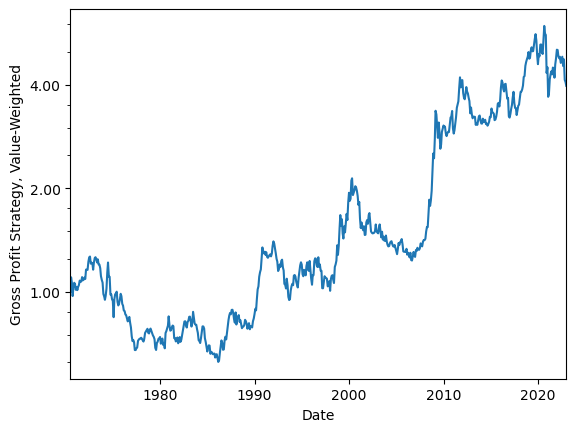

In [263]:
# Imports
from IPython.display import display, Markdown, Latex, clear_output
import numpy as np
import pandas as pd

# # These tools should remain unchanged across strategies unless you have a good reason to change them
%run portfolio_db.ipynb
%run backtest_executor.ipynb # if you were live trading a strategy, this would be replace by code that submitted orders etc

# Data processor, in charge of loading and doling out data
data_processor = GPDataProcessor() 


%run portfolio_db.ipynb
portfolio_db = PortfolioDB()

# Strategy logic, in charge of choosing trades based on current portfolio and data
# This exact code would be used for live trading 
trading_rule = GPTradingRule(portfolio_db)

# Trade executor, in charge of "executing" trades the strategy decides on, turning them into transactions and updating the portfolio
trade_executor = BacktestExecutor(portfolio_db)

# Info about the strategy, used for ex-post statistics and output not the actual backtest
strategy_info = {
    'brief descriptor': 'gp_dec_ew', 
    'plot descriptor': 'Gross Profit Strategy, Value-Weighted',
    'universe': 'Public US equities with accounting data',
    'signals': 'Gross Profitability, measured at most recent earnings announcement',
    'trading rule': 'Buy top 10% by GP ratio, short bottom 10%, value-weighted',
    'holding period': 'One month',
    'periods per year': 12,
    'time lag': 'Minimum of {0} days from announcement of quarterly earnings'.format(data_processor.min_accounting_lag),
    'output folder name': 'Output'
}

# Statistician, used to tabulate and plot statistics after the backtest runs
%run backtest_statistician.ipynb
statistican = BacktestStatistican(portfolio_db,strategy_info)
# Step 3: Run actual backtest
# Do NOT edit this cell without a very good reason

# Add 100 initial cash to our portfolios
portfolio_db.add_cash(100)

# Get our list of unique dates
udates = data_processor.unique_dates()

# Main loop for the backtest
for date in udates:
    # dataframes for the date
    signal_df = data_processor.signal_df_for_date(date)
    price_df = data_processor.price_df_for_date(date)

    # Update prices to reflect the new values after however much time has passed
    # Need to dot his first each date because the updated prices may affect our trading rule
    portfolio_db.update_prices(price_df)
    
    # Ask the trading rule what trades we should make
    open_trades_df, close_trades_df = trading_rule.compute_trades(signal_df=signal_df)

    # apply dates to trades
    open_trades_df.loc[:,'open_datetime'] = date
    close_trades_df.loc[:,'close_datetime'] = date

    # execute trades
    trade_executor.execute_opens(open_trades_df=open_trades_df, price_df=price_df)
    trade_executor.execute_closes(close_trades_df=close_trades_df, price_df=price_df)    
    
    # Record account data for today
    portfolio_db.record_account_data(price_df=price_df,datetime=date)
    
    # Do some fancy output tracking our NAV and margin requirement each day
    clear_output(wait=True)
    display( np.datetime_as_string(np.datetime64(date), unit='D') + ': ' + str(portfolio_db.current_nav()) + " | " + str(portfolio_db.current_margin()))
    
# Now that the loop is done, tell the statistican to output stats
statistican.output_stats()